In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import albumentations as alb

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# the code is used for data agumentation process here i created 3 folders full,broken,mixed
# and copy pasted images to those folders and with the help of the following code
# for full grain images i looped for 10 times and for others 14 times to generate the data and store it to data folder
# and in data folder i again created 3 folders named ['broken_grain', 'full_grain', 'mixed_grain']
# after each round of data augmentation i moved those images to respective folders

'''
from albumentations import Compose,Resize,HorizontalFlip,Rotate,RandomBrightnessContrast,RandomGamma

full_path = 'full'
broken_path = 'broken'
mixed_path = 'mixed'
output_path = 'data

# Define the augmentations
augmentations = Compose([
    Resize(512, 512),
    HorizontalFlip(p=0.5),
    Rotate(limit=30, p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
])

img_list = os.listdir(mixed_path)

counter = 0
for i in range(14):
    for img_name in img_list:
        path2img = os.path.join(mixed_path, img_name)
        image = cv2.imread(path2img)
        if image is None:
            print(f"Unable to read image {path2img}")
            continue
        for j in range(14):
            augmented_image = augmentations(image=image)["image"]
            output_img_name = f"{counter}_{img_name}"
            output_path_img = os.path.join(output_path, output_img_name)
            cv2.imwrite(output_path_img, augmented_image)
            counter += 1
            if counter >= 600:
                break
        if counter >= 600:
            break
    if counter >= 600:
        break
        
'''

'\nfrom albumentations import Compose,Resize,HorizontalFlip,Rotate,RandomBrightnessContrast,RandomGamma\n\nfull_path = \'full\'\nbroken_path = \'broken\'\nmixed_path = \'mixed\'\noutput_path = \'data\n\n# Define the augmentations\naugmentations = Compose([\n    Resize(512, 512),\n    HorizontalFlip(p=0.5),\n    Rotate(limit=30, p=0.5),\n    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),\n    RandomGamma(gamma_limit=(80, 120), p=0.5),\n])\n\nimg_list = os.listdir(mixed_path)\n\ncounter = 0\nfor i in range(14):\n    for img_name in img_list:\n        path2img = os.path.join(mixed_path, img_name)\n        image = cv2.imread(path2img)\n        if image is None:\n            print(f"Unable to read image {path2img}")\n            continue\n        for j in range(14):\n            augmented_image = augmentations(image=image)["image"]\n            output_img_name = f"{counter}_{img_name}"\n            output_path_img = os.path.join(output_path, output_img_name)\n   

In [4]:
data_dir = "data"

In [5]:
Image_size = 512
Batch_size = 32
Channels = 3
Epochs = 5

In [6]:
data = tf.keras.utils.image_dataset_from_directory('data',shuffle=True,
                                                    image_size=(Image_size,Image_size),
                                                    batch_size=Batch_size)

Found 1776 files belonging to 3 classes.


In [7]:
classes = data.class_names
classes

['broken_grain', 'full_grain', 'mixed_grain']

In [8]:
len(data)

56

In [9]:
for image_batch, label_batch in data.take(1) :
    print (image_batch.shape)
    print (label_batch.numpy( ))

(32, 512, 512, 3)
[1 0 1 0 1 0 1 0 1 2 0 1 2 1 1 1 0 1 2 0 2 1 2 2 2 1 2 2 2 0 2 0]


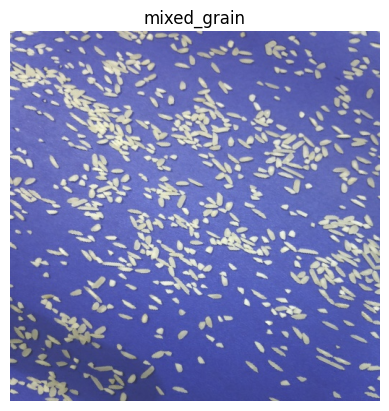

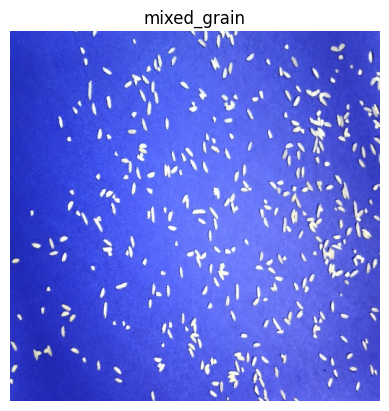

In [10]:
for image_batch, label_batch in data.take(1):
    for x in range(2):
        plt.imshow(image_batch[x].numpy().astype('uint8'))
        plt.title(classes[label_batch[x]])
        plt.axis('off')
        plt.show()

In [11]:
train_ds = data.take(int(len(data)*.7))
validation_ds = data.skip(int(len(data)*.7)).take(int(len(data)*.2))
test_ds = data.skip(int(len(data)*.9)).take(int(len(data)*.1))

In [12]:
len(train_ds),len(validation_ds),len(test_ds)

(39, 11, 5)

In [13]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds= validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
#dir(tf.keras.applications)

In [16]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', input_shape=(512, 512, 3), include_top=False)

In [17]:
base_model.trainable = False

input = keras.Input(shape=(512, 512, 3))
x = base_model(input, training=False)

x = keras.layers.Conv2D(16, (1, 1), activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv2D(32, (1, 1), activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(64, (1, 1), activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)

x = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=input, outputs=x)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        32784     
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        544       
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        2112  

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks = myCallback()

In [21]:
hist = model.fit(train_ds, epochs=Epochs,batch_size = Batch_size,validation_data=validation_ds, callbacks=[callbacks])

Epoch 1/5
39/39 [==============================] - 204s 5s/step - loss: 0.9203 - accuracy: 0.6186 - val_loss: 0.4632 - val_accuracy: 0.8835
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9808
Reached 97% accuracy so cancelling training!
39/39 [==============================] - 214s 6s/step - loss: 0.1029 - accuracy: 0.9808 - val_loss: 1.2897e-04 - val_accuracy: 1.0000


In [22]:
def predict(model, img) :
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0 ) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class= classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class,confidence

1/1 [==============================] - 0s 177ms/step


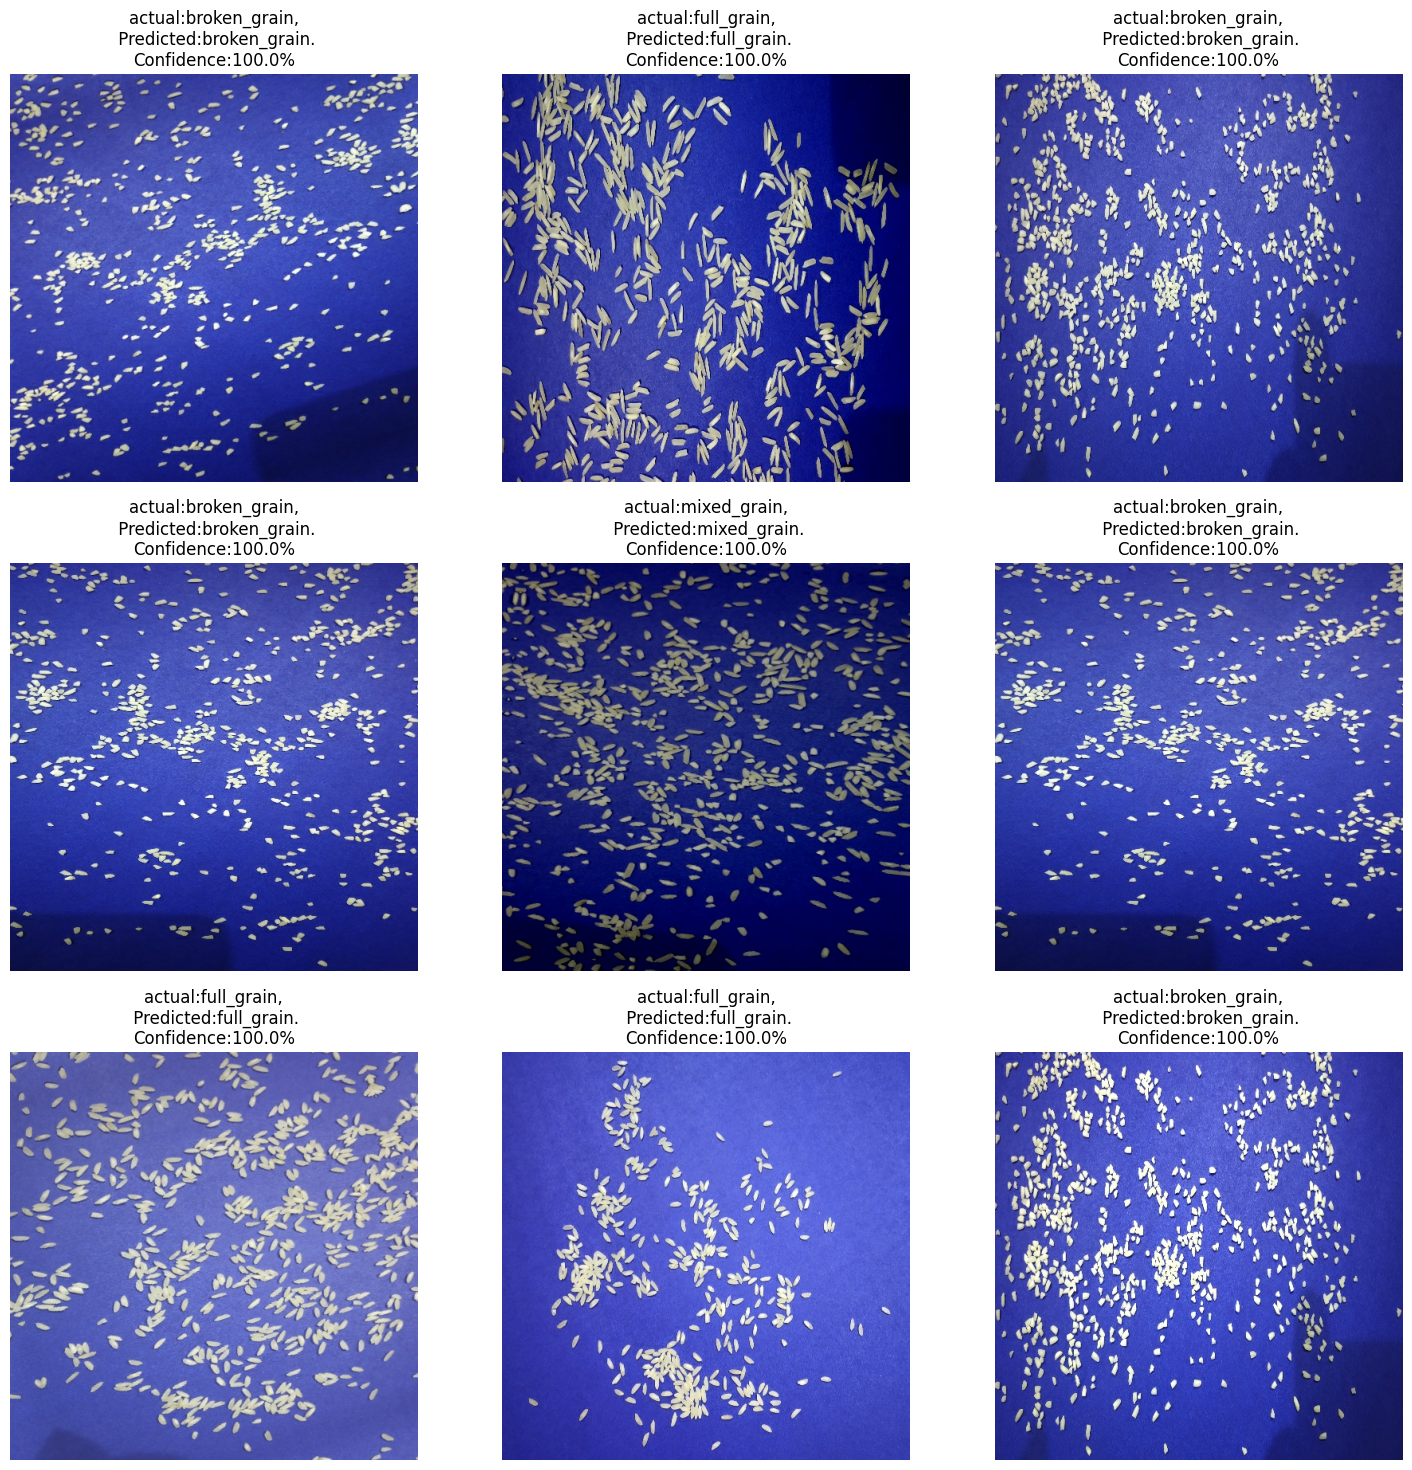

In [23]:
plt.figure(figsize=(18,18))

for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f'actual:{actual_class},\n Predicted:{predicted_class}.\nConfidence:{confidence}%')
        
        plt.axis('off')

In [24]:
model.save('ResNet50_model.h5')

In [25]:
loaded_model = tf.keras.models.load_model('ResNet50_model.h5')